In [121]:
# Time and memory tracker
import time
import numexpr
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from functools import wraps
from scipy.special import comb
from memory_profiler import memory_usage, LogFile

%load_ext memory_profiler

# LP Shortest Path
import networkx as nx
from pulp import *

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [122]:
RANDOM_SEED1 = 5 # Set the seed to make repeatable
RANDOM_SEED2 = 6 # Set the seed to make repeatable
NUM_RUNS = 10 # Number of sets of OD pairs to run algorithm with
NUM_EDGES = 10000 # Number of edges to sample from wiki dataset

## Time Tracker Decorator

In [123]:
# Time decorator code adapted from:
#   https://stackoverflow.com/questions/3620943/measuring-elapsed-time-with-the-time-module
# Key changes:
#   time.monotonic() instead of time.time()
#   print_prof_data() function revamped to show function / calls / total / average / max in tabular format

PROF_DATA = {}
DATA_CATEGORIES = {}

def profile(tag):

    def profile_wrapper(fn):

        @wraps(fn)
        def with_profiling(*args, **kwargs):
            start_time = time.monotonic()
        
            ret = fn(*args, **kwargs)
        
            elapsed_time = time.monotonic() - start_time

            if fn.__name__ not in PROF_DATA:
                PROF_DATA[fn.__name__] = [0, []]
            PROF_DATA[fn.__name__][0] += 1
            PROF_DATA[fn.__name__][1].append(elapsed_time)
            if fn.__name__ not in DATA_CATEGORIES:
                DATA_CATEGORIES[fn.__name__] = tag

            return ret

        return with_profiling

    return profile_wrapper

def print_prof_data():
    print("\n{:>25}\t{:>8}\t{:>12}\t{:>12}\t{:>12}\t{:>12}".format("Function", "Calls", "Total", "Average", "Std dev", "Maximum"))
    print(108 * "_" + "\n")
    total_calls = 0
    grand_time = 0
    for fname, data in PROF_DATA.items():
        total_calls += data[0]
        total_time = sum(data[1])
        grand_time += total_time
        avg_time = np.mean(data[1])
        std_time = np.std(data[1])
        max_time = max(data[1])
        print("{:>25s}\t{:8d}\t{:12.6f}\t{:12.6f}\t{:12.6f}\t{:12.6f}".format(fname + " — " + DATA_CATEGORIES[fname], data[0], total_time, avg_time, std_time, max_time))
    print(108 * "_")
    print("\n{:>25}\t{:8d}\t{:>12.6f}\t{:12.6f}".format("ALL FUNCTIONS COMBINED", total_calls, grand_time, grand_time / total_calls))

def clear_prof_data():
    global PROF_DATA
    PROF_DATA = {}

def clear_data_categories():
    global DATA_CATEGORIES
    DATA_CATEGORIES = {}
    
def organize_result(PROF_DATA, DATA_CATEGORIES):
    # We can also export PROF_DATA to a DataFrame for nicer display and possibly also for future use
    # Display the refined dataframe so that …
    #   1. It suppresses the individual times, without deleting that information
    #   2. It is sorted in descending order of total time taken

    profile_frame = pd.DataFrame(PROF_DATA)
    profile_frame = profile_frame.transpose()
    profile_frame.columns = ["calls", "times"]
    profile_frame["total"] = profile_frame.times.map(sum)
    profile_frame["average"] = profile_frame.times.map(np.mean)
    profile_frame["std_dev"] = profile_frame.times.map(np.std)
    profile_frame["maximum"] = profile_frame.times.map(max)
    profile_frame["minimum"] = profile_frame.times.map(min)
    for function in profile_frame.index:
        profile_frame.loc[function, "category"] = DATA_CATEGORIES[function]

    print("\t*** Timekeeping summary of profiled functions ***\n")
    print("{:d} profiled functions took {:d} calls for {:.6f} total seconds, an average of {:.6f}.".format(len(profile_frame), profile_frame.calls.sum(), profile_frame.total.sum(), profile_frame.total.mean()))

    results = profile_frame.loc[:, ["category", "calls", "total", "average", "std_dev", "maximum", "minimum"]].sort_values(by = "total", ascending = False)
    
    return profile_frame, results

### Test and POC of the Time Tracker Decorator

In [124]:
# Test the time decorator function — Set up

@profile("numpy")
def factorial(n):
    """Assumes n is an integer > 0
        Returns n!"""
    if n == 0:
        return 1
    elif n == 1:
        return n
    else:
        return n * factorial(n - 1)

@profile("numpy")
def permutations(n, r):
    """ Assumes n, k are integers > 0
        Returns nPr """
    nPr = factorial(n)/factorial(n - r)
    nPr = int(round(nPr))
    return nPr

@profile("numpy")
def combinations(n, r):
    """ Assumes n, k are integers > 0
        Returns nCr """
    nCr = permutations(n, r)/factorial(r)
    nCr = int(round(nCr))
    return nCr

# Test the time decorator function — Write a tiny Fibonnaci triangle

for i in range(0, 13):
    for j in range(i + 1):
        print(combinations(i, j), "\t", end = "")
        # print("C({:d}, {:d}) = {:d}\t".format(i, j, combinations(i, j)), end = "")
    print("\n")

print_prof_data()

1 	

1 	1 	

1 	2 	1 	

1 	3 	3 	1 	

1 	4 	6 	4 	1 	

1 	5 	10 	10 	5 	1 	

1 	6 	15 	20 	15 	6 	1 	

1 	7 	21 	35 	35 	21 	7 	1 	

1 	8 	28 	56 	70 	56 	28 	8 	1 	

1 	9 	36 	84 	126 	126 	84 	36 	9 	1 	

1 	10 	45 	120 	210 	252 	210 	120 	45 	10 	1 	

1 	11 	55 	165 	330 	462 	462 	330 	165 	55 	11 	1 	

1 	12 	66 	220 	495 	792 	924 	792 	495 	220 	66 	12 	1 	


                 Function	   Calls	       Total	     Average	     Std dev	     Maximum
____________________________________________________________________________________________________________

        factorial — numpy	    1483	    0.009506	    0.000006	    0.000005	    0.000030
     permutations — numpy	      91	    0.002139	    0.000024	    0.000010	    0.000052
     combinations — numpy	      91	    0.003001	    0.000033	    0.000011	    0.000062
____________________________________________________________________________________________________________

   ALL FUNCTIONS COMBINED	    1665	    0.014646	    0.000009


In [125]:
# Test the time decorator function — Set up

@profile("scipy")
def scipy_comb(n, r):
    """ Assumes n, k are integers > 0
        Returns nCr """
    nCr = comb(n, r, exact = True)
    # nCr = int(round(nCr))
    return nCr

# Test the time decorator function — Write a tiny Fibonnaci triangle

for i in range(0, 13):
    for j in range(i + 1):
        print(scipy_comb(i, j), "\t", end = "")
        # print("C({:d}, {:d}) = {:d}\t".format(i, j, combinations(i, j)), end = "")
    print("\n")

print_prof_data()

1 	

1 	1 	

1 	2 	1 	

1 	3 	3 	1 	

1 	4 	6 	4 	1 	

1 	5 	10 	10 	5 	1 	

1 	6 	15 	20 	15 	6 	1 	

1 	7 	21 	35 	35 	21 	7 	1 	

1 	8 	28 	56 	70 	56 	28 	8 	1 	

1 	9 	36 	84 	126 	126 	84 	36 	9 	1 	

1 	10 	45 	120 	210 	252 	210 	120 	45 	10 	1 	

1 	11 	55 	165 	330 	462 	462 	330 	165 	55 	11 	1 	

1 	12 	66 	220 	495 	792 	924 	792 	495 	220 	66 	12 	1 	


                 Function	   Calls	       Total	     Average	     Std dev	     Maximum
____________________________________________________________________________________________________________

        factorial — numpy	    1483	    0.009506	    0.000006	    0.000005	    0.000030
     permutations — numpy	      91	    0.002139	    0.000024	    0.000010	    0.000052
     combinations — numpy	      91	    0.003001	    0.000033	    0.000011	    0.000062
       scipy_comb — scipy	      91	    0.000104	    0.000001	    0.000001	    0.000006
_____________________________________________________________________________________

In [126]:
profile_frame, result = organize_result(PROF_DATA, DATA_CATEGORIES)
result

	*** Timekeeping summary of profiled functions ***

4 profiled functions took 1756 calls for 0.014750 total seconds, an average of 0.003687.


,category,calls,total,average,std_dev,maximum,minimum
factorial,numpy,1483,0.009506,0.000006,5.255472e-06,0.000030,2.059969e-07
combinations,numpy,91,0.003001,0.000033,1.105567e-05,0.000062,1.251500e-05
permutations,numpy,91,0.002139,0.000024,9.686349e-06,0.000052,7.679002e-06
scipy_comb,scipy,91,0.000104,0.000001,7.464582e-07,0.000006,6.920018e-07


             calls     total   average   std_dev   maximum       minimum
factorial     1483  0.009506  0.000006  0.000005  0.000030  2.059969e-07
combinations    91  0.003001  0.000033  0.000011  0.000062  1.251500e-05
permutations    91  0.002139  0.000024  0.000010  0.000052  7.679002e-06


           calls     total   average       std_dev   maximum       minimum
scipy_comb    91  0.000104  0.000001  7.464582e-07  0.000006  6.920018e-07


category
numpy    0.014646
scipy    0.000104
Name: total, dtype: float64


factorial       0.009506
permutations    0.002139
combinations    0.003001
scipy_comb      0.000104
Name: total, dtype: float64


([<matplotlib.patches.Wedge at 0x7fd11995c240>,
 [Text(-0.5041969507295252, 1.033578944674788, 'factorial'),
  Text(-0.2368929314236217, -1.1253362782037748, 'permutations'),
  Text(0.8916893653150345, -0.7262162734227807, 'combinations'),
  Text(1.2996812834812566, -0.02878474193933914, 'scipy_comb')])

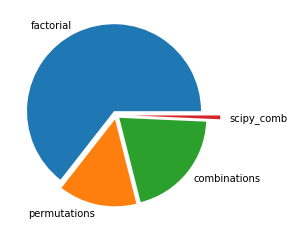

In [127]:
print(profile_frame[profile_frame.category == "numpy"].loc[:, ["calls", "total", "average", "std_dev", "maximum", "minimum"]].sort_values(by = "total", ascending = False))
print('\n')
print(profile_frame[profile_frame.category == "scipy"].loc[:, ["calls", "total", "average", "std_dev", "maximum", "minimum"]].sort_values(by = "total", ascending = False))
print('\n')
print(profile_frame.total.groupby(profile_frame.category).sum())
print('\n')
print(profile_frame["total"])
plt.pie(profile_frame.total * 100, explode = (0.05, 0.05, 0.05, 0.2), labels = profile_frame.index)

In [128]:
# ERROR: TypeError: Image data of dtype object cannot be converted to float
# plt.figure(figsize = (9, 5.5))
# plt.imshow([profile_frame.loc["combinations", "times"], 
#             profile_frame.loc["permutations", "times"], profile_frame.loc["scipy_comb", "times"]], aspect = "auto", interpolation = "none", cmap = "viridis")
# plt.colorbar()
# plt.savefig("profile_frame_time_matrix.png")

# The Algorithms

### Define common data and functions

In [129]:
def initiate_graph(num_edges):
    G = nx.read_gexf('./data/math_wikipedia_pages_links_dict.gexf')
    G_2 = G.to_directed()

    # Choose subset of wikipedia dataset to test algorithms
    def random_subset_of_arcs(arcs, subset_size):
      """Used to take a random subset of arcs and return a sample
      Can be used in conjunction with the below sampled_edges in a loop"""
      num_arcs = len(arcs)
      selections = random.sample(range(1,num_arcs), subset_size)
      return selections

    def choose_random_nodes(list_of_nodes):
      """Chooses 2 random nodes for testing"""
      num_nodes = len(list_of_nodes)
      node_a, node_b = random.sample(range(0,num_nodes),2)
      return (node_a, node_b)

    # Returns edge samples # Can be used to create a subgraph
    sampled_edges = list(map(list(G.edges).__getitem__, random_subset_of_arcs(list(G.edges),num_edges)))

    # Looks up the nodes in the sampled edges and returns that
    sampled_nodes = list(pd.Series([node for edge in sampled_edges for node in edge]).unique())

    return sampled_nodes, sampled_edges
    
sampled_nodes, sampled_edges = initiate_graph(NUM_EDGES)

# Define nodes to test with
random.seed(RANDOM_SEED1)
start_nodes_keys_list = random.sample(sampled_nodes,NUM_RUNS)

random.seed(RANDOM_SEED2)
end_nodes_keys_list = random.sample(sampled_nodes,NUM_RUNS)

In [130]:
# # Initiating new time tracker
clear_prof_data()
clear_data_categories()


### Define general functions for LPs

In [131]:
def create_arcs(sampled_nodes, sampled_edges, start_node_key, end_node_key): 

    # Creates a dictionary of the node IDs to the values for later lookup and reverse lookup
    nodes_ = sampled_nodes
    nodes_dict = dict(zip(range(0,len(nodes_)),nodes_)) #    {0: 'Hanover', 1: 'Gottfried_Wilhelm_Leibniz',..}
    nodes_dict_rev = dict(zip(nodes_,range(0,len(nodes_))))# {'Hanover': 0,'Gottfried_Wilhelm_Leibniz': 1,..}
    nodes_ = list(nodes_dict.keys())

    # Define start and end node. Node A to B
    start_node = nodes_dict_rev[start_node_key]
    end_node = nodes_dict_rev[end_node_key]

    # Create a dictionary of nodes and their net demands
    # Iterates through each node and adds it to the node demand
    # dictionary with a net demand of 0, then sets the supply
    # and demand node of the network problem to -1 and 1respectively
    net_ds_nodes_ = {} #{0: [-1, 0], 1: [0, 0], 2: [0, 0],... 8: [0,1], ... }
    for node in nodes_:
        net_ds_nodes_[node] = [0,0]
    net_ds_nodes_[start_node] = [-1,0]
    net_ds_nodes_[end_node] = [0,1]

    #Creates a dictionary of arcs3
    arcs_ = sampled_edges

    #Creates a dictionary for each arc and swapping the node values for node IDs
    arcs_dict = {}
    """
    example output for arcs_dict:
    {(0, 1): ('Hanover', 'Gottfried_Wilhelm_Leibniz'),
     (0, 2): ('Hanover', 'Carl_Friedrich_Gauss'),
    """
    for a,b in arcs_:
        x = nodes_dict_rev[a]
        y = nodes_dict_rev[b]
        arcs_dict[(x,y)] = (a,b)

    arcs_ = list(arcs_dict.keys())
    return nodes_, arcs_, net_ds_nodes_, start_node, end_node

def run_LP(prob_):
    prob_.solve()    
    return value(prob_.objective)

## Base Linear Program

### Define base LP

In [132]:
def define_base_lp(nodes_, arcs_, net_ds_nodes_, start_node, end_node):
    # Costs, lower bound, upper bound
    arcData_ = dict(zip(arcs_, [[1,0,1]]*len(arcs_)))

    # Makes it easy to reference a dictionary with subdicts
    supply_,demand_ = splitDict(net_ds_nodes_)
    (costs_,mins_,maxs_) = splitDict(arcData_)

    # Create LP Problem    
    prob_ = LpProblem("Shortest Path, Minimum Cost Problem",LpMinimize)

    # Create variables
    LpVars_ = LpVariable.dicts("Route", arcs_, 0, None, LpInteger)

    # Set bounds on variables
    for a in arcs_:
        LpVars_[a].bounds(mins_[a], maxs_[a])

    #Objective Function
    prob_ += lpSum([LpVars_[a]  for a in arcs_]), "Shortest Path" 
  
    # Constraints:
    #For each node that is not a start node or end note, set the inflow = outflow so that the
    #"path" of clicks must go THROUGH the node
    for n in nodes_:
        if ((n == start_node) or (n == end_node)):
            continue
        #Balance-of-flow constraints [ inflow - outflow  = net demand]
        # since net demand is 0 for most of the nodes, inflow = outflow is the constraint
        prob_ += (lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if j == n]) - lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if i == n])) == 0,\
                 "Flow Conservation in Node {}".format(n)

    #Start and end node constraints, indicating supply node (-1) and demand node (1).
    #AKA the sender node (-1) and the receiver node (1)
    # prob_ += -lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if i == start_node]) == -1
    # prob_ += lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if j == end_node]) == 1

    prob_ += (lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if j == start_node]) -\
             lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if i == start_node])) == -1

    prob_ += (lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if j == end_node]) -\
             lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if i == end_node])) == 1

    #prob_.constraints
    prob_.writeLP(r"network_flow_wikipedia.lp")
    
    return prob_

###  Running the base LP

In [133]:
# Function for time tracking
@profile("base_lp")
def run_base_lp(i):
    start_node_key = start_nodes_keys_list[i]
    end_node_key = end_nodes_keys_list[i]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes, sampled_edges, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)
    return clicks

# Function for memory tracking
def run_base_lp_once():
    start_node_key = start_nodes_keys_list[0]
    end_node_key = end_nodes_keys_list[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes, sampled_edges, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)

# Time tracking
for n in range(0,NUM_RUNS): 
    run_base_lp(n)
    
# Memory tracking
base_lp_memory = memory_usage(run_base_lp_once)

## Dual Linear Program

### Define the dual LP

In [134]:
def define_dual_lp(nodes_, arcs_, net_ds_nodes_, start_node, end_node):    
    # Create LP Problem    
    prob_ = LpProblem("Shortest Path, Minimum Cost Problem",LpMaximize)
    
    # Create variables
    LpVars_ = LpVariable.dicts("Nodes", nodes_, 0, None, LpInteger)
    
    # Objective Function
    prob_ += lpSum(-LpVars_[start_node] + LpVars_[end_node]), "Shortest Path"
    
    for e in arcs_:
      u = LpVars_[e[0]]
      v = LpVars_[e[1]]
      prob_ += v - u  <= 1, "Constraint at each Edge {}".format(e)

    prob_ += LpVars_[start_node] == 0
    return prob_

### Running the dual LP

In [135]:
# Time tracking
@profile("dual_lp")
def run_dual_lp(i):
    start_node_key = start_nodes_keys_list[i]
    end_node_key = end_nodes_keys_list[i]

    nodes_dual, arcs_dual, net_ds_nodes_dual, start_node, end_node = \
        create_arcs(sampled_nodes, sampled_edges, start_node_key, end_node_key)
    prob = define_dual_lp(nodes_dual, arcs_dual, net_ds_nodes_dual, start_node, end_node)
    clicks = run_LP(prob)
    return clicks

# Memory tracking
def run_dual_lp_once():
    start_node_key = start_nodes_keys_list[0]
    end_node_key = end_nodes_keys_list[0]

    nodes_dual, arcs_dual, net_ds_nodes_dual, start_node, end_node = \
        create_arcs(sampled_nodes, sampled_edges, start_node_key, end_node_key)
    prob = define_dual_lp(nodes_dual, arcs_dual, net_ds_nodes_dual, start_node, end_node)
    clicks = run_LP(prob)

# Time tracking    
for n in range(0,NUM_RUNS): 
    run_dual_lp(n)
    
# Memory tracking
dual_lp_memory = memory_usage(run_dual_lp_once)

## Dijkstra's Shortest Path

In [146]:
@profile("dijkstra")
def run_dijkstra(i): 
    start_node_key = start_nodes_keys_list[i]
    end_node_key = end_nodes_keys_list[i]
    shortest_path = nx.shortest_path(G,source = start_node_key, target = end_node_key, method = 'dijkstra')

def run_dijkstra_once():
    start_node_key = start_nodes_keys_list[0]
    end_node_key = end_nodes_keys_list[0]
    shortest_path = nx.shortest_path(G,source = start_node_key, target = end_node_key, method = 'dijkstra')

# Time tracking    
for n in range(0,NUM_RUNS): 
    run_dijkstra(n)
    
# Memory tracking
dijkstra_memory = memory_usage(run_dijkstra_once)

## A-star (A*) Shortest Path

In [148]:
@profile("a*")
def run_astar(i): 
    start_node_key = start_nodes_keys_list[i]
    end_node_key = end_nodes_keys_list[i]
    shortest_path = nx.astar_path(G,source = start_node_key, target = end_node_key)

def run_astar_once():
    start_node_key = start_nodes_keys_list[0]
    end_node_key = end_nodes_keys_list[0]
    shortest_path = nx.astar_path(G,source = start_node_key, target = end_node_key)

# Time tracking    
for n in range(0,NUM_RUNS): 
    run_astar(n)
    
# Memory tracking
astar_memory = memory_usage(run_astar_once)

# Time Results

In [149]:
profile_frame, result = organize_result(PROF_DATA, DATA_CATEGORIES)
result

	*** Timekeeping summary of profiled functions ***

4 profiled functions took 40 calls for 78.796150 total seconds, an average of 19.699038.


,category,calls,total,average,std_dev,maximum,minimum
run_base_lp,base_lp,10,70.001854,7.000185,0.468865,7.849920,6.021927
run_dual_lp,dual_lp,10,6.949832,0.694983,0.101591,0.853050,0.528448
run_astar,a*,10,1.837688,0.183769,0.055003,0.250242,0.064854
run_dijkstra,dijkstra,10,0.006776,0.000678,0.000403,0.001510,0.000170


# Memory Results

In [150]:
memory_df = pd.DataFrame()
memory_df["Algorithm"] = ["Base LP", "Dual LP", "Dijkstra", "A*"]
memory_df["Peak Memory Usage"] = [max(base_lp_memory), max(dual_lp_memory), max(dijkstra_memory), max(astar_memory)]
memory_df["Avg Memory Usage"] = [np.mean(base_lp_memory), np.mean(dual_lp_memory), np.mean(dijkstra_memory), np.mean(astar_memory)]
print(memory_df)

  Algorithm  Peak Memory Usage  Avg Memory Usage
0   Base LP         623.800781        623.800736
1   Dual LP         623.582031        623.582031
2  Dijkstra         623.585938        623.585938
3        A*         623.589844        623.589844


In [144]:
# plt.grid()
# plt.title("Comparing two functions and their memory usage")
# plt.plot(base_lp_memory - np.min(base_lp_memory), color = "blue", label = "Lambert W")
# # plt.plot(pigpen - np.min(pigpen), color = "red", label = "Memory hog")
# # plt.legend(loc = "upper right")
# # plt.savefig("lambert_versus_hog.png")